In [ ]:
!pip install umap-learn

In [1]:
import pandas as pd
import transformers
import os
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pickle
import torch
import umap

2025-05-18 16:29:13.056271: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747585753.073932 3482509 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747585753.079251 3482509 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-18 16:29:13.104321: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def get_dict_embeds(file_name):
    with open(file_name, 'rb') as embeds_file:
        dict_embeds = pickle.load(embeds_file)
    return dict_embeds

In [5]:
train_dict_embeds = get_dict_embeds((os.path.join(os.path.expanduser('~/work/informed_undersampling/cmsb_run_1'), 
                                                  'cmsb_embeds_1.pkl')))

In [7]:
def get_embeds(dict_embeds):
    # GEtting the first sentence_id along with the corresponding tensor
    key = list(dict_embeds.keys())[0]
    #Adding a dimension for enabling the cat operation
    tensor_embeds = dict_embeds[key].unsqueeze(0)
    for key in list(dict_embeds)[1:]:
        tensor_embeds = torch.cat((tensor_embeds, dict_embeds[key].unsqueeze(0)), dim = 0)
    return tensor_embeds

In [8]:
train_embeds = get_embeds(train_dict_embeds)

# Plotting the training data embeddings
Since the embeddings have been loaded to their respective variables from the pickle files, we will do the following:
1. Apply TSNE to calculate a 2d representation of the 768 dimensional embeddings
2. Then plot the points in terms of the numeric labels (0: sexist, 1: non-sexist)

In [9]:
def get_ids_embeds(embeds, dict_embeds, df_name, type_data):
    #embed_ds = TSNE(n_components = 2).fit_transform(embeds)
    embed_ds = umap.UMAP(n_neighbors = 15, n_components = 2, metric = 'euclidean').fit_transform(embeds)
    df_embeds = pd.DataFrame(embed_ds).rename(columns = {0 : 'x', 1: 'y'})
    df_ids = pd.DataFrame(list(dict_embeds.keys())).rename(columns = {0 : 'id'})
    df_ids_embeds = pd.concat([df_ids, df_embeds], axis = 1)
    df_text_scores = pd.read_csv(df_name)
    df_text_scores_embeds = pd.merge(df_text_scores, df_ids_embeds, on = 'id', how = 'inner')
    if type_data == 'train':
        df_text_scores_embeds = df_text_scores_embeds[['id', 'text', 'sexist', 'numeric_labels', 'average_pvi',
                                       'average_el2n', 'average_vog', 'x', 'y', 'misclassification_number']].reset_index(drop = True)
    else:
        df_text_scores_embeds = df_text_scores_embeds[['id', 'text', 'sexism', 'x', 'y']]
    return df_text_scores_embeds

In [10]:
df_train_embeds = get_ids_embeds(train_embeds, train_dict_embeds, 'sexist_data_final_train.csv', 'train')

/opt/conda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [11]:
df_train_embeds.to_csv('sexist_data_train_embeds.csv', index = False)

In [12]:
#df_sexism_eval_embeds = get_ids_embeds(sexism_eval_embeds, sexism_eval_dict_embeds, os.path.join('ood_datasets', 'sexism_eval.csv'), type_data = None)

In [13]:
#df_sexism_eval_embeds.to_csv('sexism_eval_embeds.csv', index = False)

In [14]:
#df_ood_1_embeds = get_ids_embeds(ood_1_embeds, ood_1_dict_embeds, os.path.join('ood_datasets', 'ood_1.csv'), type_data = None)
#df_ood_2_embeds = get_ids_embeds(ood_2_embeds, ood_2_dict_embeds, os.path.join('ood_datasets', 'ood_2.csv'), type_data = None)

In [15]:
#df_ood_1_embeds.to_csv('ood_1_embeds.csv', index = False)
#df_ood_2_embeds.to_csv('ood_2_embeds.csv', index = False)

In [27]:
df_train_embeds = pd.read_csv('sexist_data_train_embeds.csv')

In [28]:
df_train_embeds

,id,text,sexist,numeric_labels,average_pvi,average_el2n,average_vog,x,y,misclassification_number
0,2651,SIIIIGH http://t.co/BpJX5JwhlH,False,0,0.134662,0.043008,-0.001590,13.319992,4.448172,0
1,6089,I really dislike working with undergrads in la...,False,0,0.050947,0.119459,-0.001476,5.979629,9.904297,0
2,9786,"So calling qualified hires ""tokens"" b/c it's n...",False,0,0.065549,0.104858,-0.000092,6.088356,10.552804,0
3,10635,Noooooo #mkr whyyyyy,False,0,0.136266,0.041448,-0.001700,10.675275,6.706342,0
4,9749,I don't know ANY genuine female nerds... who w...,False,0,-0.418783,0.439067,0.002268,5.372310,5.006014,1
...,...,...,...,...,...,...,...,...,...,...
9536,5193,Young girls are entitled to as much independen...,False,0,-1.132464,0.838187,-0.004243,0.988209,6.850093,5
9537,13422,MENTION273 because everyone wants to hit kat w...,False,0,0.137385,0.040473,-0.004203,10.176671,2.318067,0
9538,5392,MENTION4461 MENTION4342 1/1 my father would sa...,True,1,0.777994,1.119228,-0.002450,5.872002,7.085317,5
9539,860,Okay I wish it was Father nature. It would con...,False,0,0.114917,0.061341,-0.004156,12.746021,3.765920,0


In [14]:
#df_sexism_pairs = pd.read_csv('sexism_paired.csv', delimiter = '\t')

In [15]:
#df_counterfactuals = df_train_embeds[df_train_embeds['id'].isin(df_sexism_pairs['counterfactual_id'])].reset_index(drop = True)
#df_counterfactuals

In [16]:
def get_data_types(misc_num):
    if misc_num <=3:
        return 'easy'
    else:
        return 'hard'
        

In [17]:
#df_train_embeds['type'] = df_train_embeds['misclassification_number'].apply(lambda x: get_data_types(x))

In [18]:
#df_train_embeds.to_csv('sexist_data_train_embeds_misclassifications.csv')

In [19]:
#df_sexist = df_train_embeds[(~df_train_embeds['id'].isin(df_counterfactuals['id'])) & (df_train_embeds['numeric_labels'] == 1)].reset_index(drop = True)
#df_non_sexist = df_train_embeds[(~df_train_embeds['id'].isin(df_counterfactuals['id'])) & (df_train_embeds['numeric_labels'] == 0)].reset_index(drop = True)

In [20]:
#df_non_sexist.shape

In [21]:
#df_sexist.shape

In [26]:
#df_counterfactuals.shape

(611, 10)

In [22]:
#df_sexist['type_data'] = 'sexist'
#df_sexist.head()

In [23]:
#df_counterfactuals['type_data'] = 'counterfactual'
#df_counterfactuals.head()

In [24]:
#df_non_sexist['type_data'] = 'non-sexist'
#df_non_sexist.head()

In [30]:
#df_final = pd.concat([df_sexist, df_counterfactuals, df_non_sexist], axis = 0).sample(frac = 1)

In [37]:
#df_final.to_csv('df_embeds.csv', index = False)

In [31]:
df_train_embeds['type_data'] = df_train_embeds['numeric_labels'].apply(lambda x: 'sexist' if x == 1 else 'non-sexist')

In [32]:
def get_plots(data):
    plt.rcParams.update({'font.size': 22})
    plt.rcParams.update({'figure.figsize': (10, 10)})
    sns.set_theme(style = "whitegrid")
    color_palette = {'sexist': 'darkorange',  'non-sexist':'royalblue'}
    markers = {'sexist':'X', 'non-sexist': 'o'} 
    fig = sns.scatterplot(data = data, x = 'x', y = 'y', hue = 'type_data', style = 'type_data', markers = markers, palette = color_palette, s = 80)
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.savefig(f'data_distribution.pdf', bbox_inches = 'tight')
    plt.show()   
    

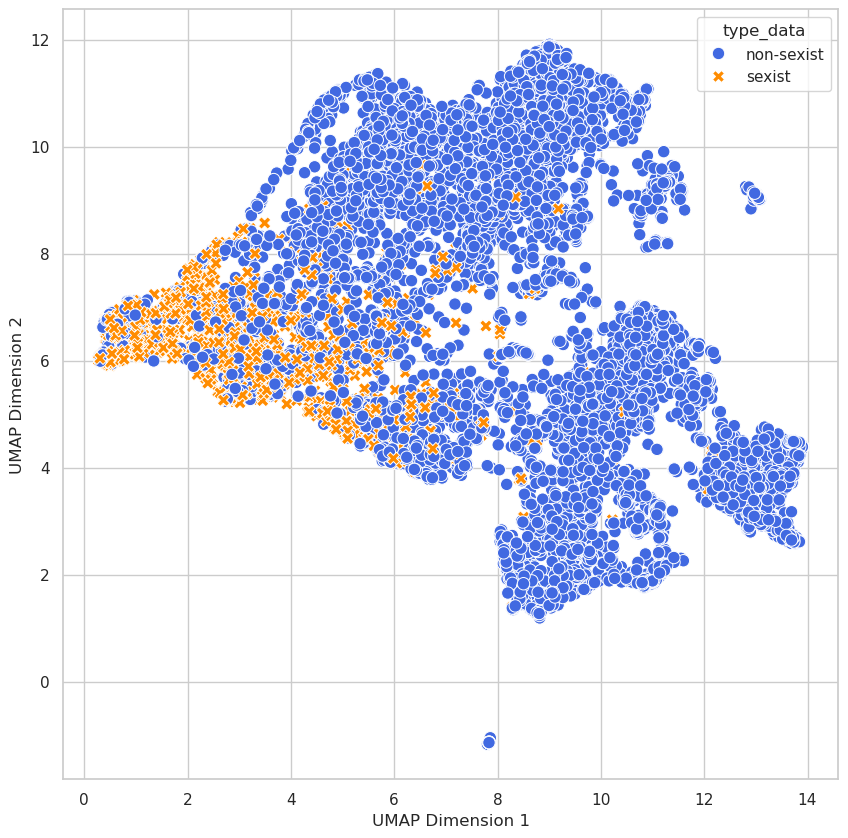

In [33]:
get_plots(df_train_embeds)